In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load


from time import time
from collections import Counter

import tqdm
from tqdm import tqdm

import pyarrow

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
azdias = pd.read_csv('./data/clean_azdias_subset.csv')
azdias.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,...,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,-1,0.0,11.0,0.0,2.0,0.0,6.0,Unknown,8,...,1.0,3.0,0.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,-1,17.0,10.0,0.0,1.0,0.0,2.0,Unknown,4,...,4.0,2.0,0.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2,13.0,1.0,0.0,0.0,0.0,4.0,Unknown,2,...,4.0,1.0,0.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,-1,20.0,3.0,0.0,4.0,0.0,2.0,Unknown,6,...,7.0,2.0,0.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0


In [3]:
azdias = azdias.drop('LNR', axis=1)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638400 entries, 0 to 638399
Columns: 272 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(246), int64(23), object(3)
memory usage: 1.3+ GB


In [4]:
def pca_results(full_dataset, pca, show_plot=True):
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance Ratio'])
    variance_ratios.index = dimensions
    cumsum = pca.explained_variance_ratio_.cumsum().reshape(len(pca.components_), 1)
    variance_cumsum = pd.DataFrame(np.round(cumsum, 4), columns = ['Explained Cumulative Variance'])
    variance_cumsum.index = dimensions

    if show_plot == True:
        fig, ax = plt.subplots(figsize = (14,8))
        ax.plot(np.arange(len(variance_cumsum)), variance_cumsum)
        ax.set_ylabel("Explained Cum. Variance")
        ax.set_xlabel("Num. of Principal Comp.")
    return pd.concat([variance_cumsum, variance_ratios, components], axis = 1)

def print_pcs(df, pca, comp, k=5):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.columns)
    pc = components.iloc[comp-1].sort_values(ascending=False)
    print(f'Weights for PC{comp}')
    print(f'Top {k} weights')
    print(pc.head(k))
    print('\n')
    print(f'Bottom {k} weights')
    print(pc.tail(k))

def comp_weights(pca, dimension_max, dimension_min , num_features, df):
    components = pd.DataFrame( np.round(pca.components_, 4), columns = df.keys())
    components.index = [i for i in range(1, len(pca.components_)+1)]

    weights_pos = components.iloc[dimension_max-1]
    weights_neg = components.iloc[dimension_min-1]
    fig, ax = plt.subplots(figsize = (15, 4), ncols=2, nrows = 1)
    weights_pos.sort_values(ascending=False)[:num_features].plot(kind='bar', ax = ax[0]);
    weights_neg.sort_values(ascending=False)[-num_features:].plot(kind='bar', ax = ax[1], color = 'red');
    
    return fig

# PCA

In [5]:
type_lookup = pd.read_csv('./data/type_lookup.csv')
model_feat =  pd.read_csv('./data/model_feat.csv')
model_feat = list(model_feat['model_feat'])

In [6]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_col = ['OST_WEST_KZ','CAMEO_DEU_2015']

for cat in cat_col:
    azdias[cat] = azdias[cat].fillna('Unknown') 
    azdias[cat] = le.fit_transform(azdias[cat])

In [7]:
clean_feat = pd.read_csv('./data/clean_features.csv')

#FILLNA NUMERICAL FEATS
num_cols = [feat for feat in model_feat if feat not in cat_col]

for cat in tqdm(num_cols):
    #print(cat)
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == cat]
    
    for val in azdias[cat]:
        try:
            val = int(val)
            if val in temp_df['Value']:
                temp_list.append(val)
            else:
                temp_list.append(99)
        except:
            temp_list.append(99)
    azdias[cat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [17:40<00:00,  3.94s/it]


In [8]:
azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,99,99,99,99,99,99,99,0,99,99,...,99,99,99,99,99,99,99,99,99,99
1,99,99,99,99,99,99,99,0,99,99,...,99,99,99,99,99,99,99,99,99,99
2,99,17,99,99,99,99,99,0,99,99,...,99,99,99,99,99,99,99,99,99,99
3,2,13,99,99,99,99,99,0,99,99,...,99,99,99,99,99,99,99,99,99,99
4,99,20,99,99,99,99,99,0,99,99,...,99,99,99,99,99,99,99,99,99,99


In [9]:
#SCALE DATAFRAME
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
azdias = scaler.fit_transform(azdias)

In [10]:
azdias = pd.DataFrame(azdias,
              columns=model_feat)

In [11]:
azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.068182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.020202,0.022727,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.000000,0.102273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
azdias.describe()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,638400.000000,638400.000000,638400.000000,638400.0,638400.0,638400.0,638400.0,638400.0,638400.0,638400.0,...,638400.0,638400.0,638400.0,638400.0,638400.0,638400.0,638400.0,638400.0,638400.0,638400.000000
mean,0.764540,0.472842,0.998564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.996765
std,0.419579,0.466738,0.037873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056782
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,1.000000,0.056818,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
50%,1.000000,0.102273,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
75%,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
max,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [12]:
azdias.to_csv('./data/clean_azdias_subset.csv',index=False)

In [18]:
pca = PCA(random_state=777)
pca.fit(azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=777,
    svd_solver='auto', tol=0.0, whiten=False)

,Explained Cumulative Variance,Explained Variance Ratio,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Dimension 1,0.5533,0.5533,-0.2473,-0.9689,0.0004,0.0000,0.0000,0.0000,-0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0005
Dimension 2,0.9872,0.4339,-0.9689,0.2473,-0.0002,0.0000,0.0000,0.0000,-0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0008
Dimension 3,0.9952,0.0081,-0.0009,-0.0002,-0.0009,0.0000,0.0000,0.0000,-0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0000
Dimension 4,0.9988,0.0036,0.0001,-0.0004,-1.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0009
Dimension 5,0.9996,0.0008,0.0003,0.0001,-0.0004,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0003
Dimension 6,1.0000,0.0004,0.0001,-0.0001,-0.0002,-0.0000,-0.0000,0.0000,-0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0002
Dimension 7,1.0000,0.0000,-0.0000,-0.0000,-0.0000,0.9983,0.0560,0.0162,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0000
Dimension 8,1.0000,0.0000,0.0000,-0.0000,0.0000,0.0450,-0.8240,0.0745,0.5598,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0000
Dimension 9,1.0000,0.0000,0.0000,0.0000,0.0000,0.0141,-0.2560,0.0139,-0.3798,0.8887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Dimension 10,1.0000,0.0000,-0.0000,0.0000,0.0000,-0.0026,-0.0127,0.2036,-0.0456,-0.0263,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0000


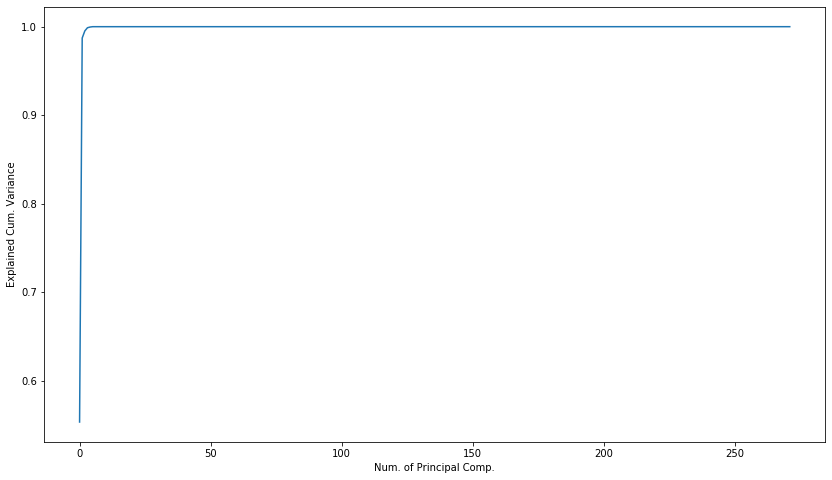

In [19]:
results = pca_results(azdias, pca)
results

In [22]:
n_components = 5
explained_variance = results.iloc[n_components, 0]
explained_variance

1.0

In [23]:
pca = PCA(n_components=n_components, random_state=777)
azdias_pca = pca.fit_transform(azdias)

In [24]:
for index in range(1,5):
    print_pcs(azdias, pca, comp=index)

Weights for PC1
Top 5 weights
ALTERSKATEGORIE_GROB    0.0005
ANZ_HAUSHALTE_AKTIV     0.0004
KBA13_ANZAHL_PKW        0.0002
KBA05_MOD1             -0.0000
KBA05_MAXAH            -0.0000
Name: 0, dtype: float64


Bottom 5 weights
KBA13_KW_120   -0.0000
KBA13_KW_121   -0.0000
KBA13_KW_30    -0.0000
AGER_TYP       -0.2473
ALTER_HH       -0.9689
Name: 0, dtype: float64
Weights for PC2
Top 5 weights
ALTER_HH                0.2473
ALTERSKATEGORIE_GROB    0.0008
KBA13_ANZAHL_PKW        0.0002
MIN_GEBAEUDEJAHR        0.0001
KBA05_MOD1             -0.0000
Name: 1, dtype: float64


Bottom 5 weights
KBA13_KRSHERST_BMW_BENZ   -0.0000
KBA13_KRSHERST_AUDI_VW    -0.0000
KBA13_KRSAQUOT            -0.0000
ANZ_HAUSHALTE_AKTIV       -0.0002
AGER_TYP                  -0.9689
Name: 1, dtype: float64
Weights for PC3
Top 5 weights
KBA13_CCM_1500   -0.0
KBA05_KW3        -0.0
KBA05_SEG1       -0.0
KBA05_MOTRAD     -0.0
KBA05_MOTOR      -0.0
Name: 2, dtype: float64


Bottom 5 weights
ALTER_HH               -0.00

In [25]:
dump(pca, 'dump/pca.joblib')

['dump/pca.joblib']

# CLUSTERING

In [26]:
scores = []
clusters = list(range(2,16,1))
for k in clusters:
    print(f'KMeans with {k} cluster')
    start = time() 
    kmeans = KMeans(n_clusters = k, random_state=785)
    model = kmeans.fit(azdias_pca)
    score = model.score(azdias_pca)
    scores.append(np.abs(score))
    end = time()
    m, s = divmod(end - start, 60)
    print(f'Finished KMeans with {k} cluster(s) in {m}m:{s}s')

KMeans with 2 cluster
Finished KMeans with 2 cluster(s) in 0.0m:2.4119813442230225s
KMeans with 3 cluster
Finished KMeans with 3 cluster(s) in 0.0m:3.334181785583496s
KMeans with 4 cluster
Finished KMeans with 4 cluster(s) in 0.0m:3.810997486114502s
KMeans with 5 cluster
Finished KMeans with 5 cluster(s) in 0.0m:5.82400369644165s
KMeans with 6 cluster
Finished KMeans with 6 cluster(s) in 0.0m:5.9979963302612305s
KMeans with 7 cluster
Finished KMeans with 7 cluster(s) in 0.0m:6.790004253387451s
KMeans with 8 cluster
Finished KMeans with 8 cluster(s) in 0.0m:9.20000171661377s
KMeans with 9 cluster
Finished KMeans with 9 cluster(s) in 0.0m:9.859001398086548s
KMeans with 10 cluster
Finished KMeans with 10 cluster(s) in 0.0m:10.752010107040405s
KMeans with 11 cluster
Finished KMeans with 11 cluster(s) in 0.0m:11.820024251937866s
KMeans with 12 cluster
Finished KMeans with 12 cluster(s) in 0.0m:13.034033298492432s
KMeans with 13 cluster
Finished KMeans with 13 cluster(s) in 0.0m:13.610025405

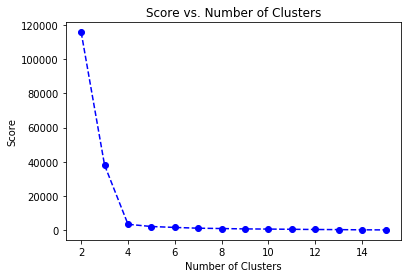

In [27]:
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of Clusters');
plt.ylabel('Score');
plt.title('Score vs. Number of Clusters')
plt.savefig('./assets/kmeans.png')
plt.show()

In [28]:
kmeans = KMeans(n_clusters = 5, random_state=777)
kmeans = kmeans.fit(azdias_pca)

In [29]:
population_labels = kmeans.labels_

In [30]:
dump(kmeans, './dump/kmeans_model.joblib')

['./dump/kmeans_model.joblib']

# CUSTOMERS

In [31]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [48]:
customers.shape

(191652, 272)

In [49]:
type_lookup = pd.read_csv('./data/type_lookup.csv')
type_lookup.head()

,attr,datatype
0,KBA13_CCM_2500,numerical
1,KBA13_HALTER_40,numerical
2,KBA05_SEG9,numerical
3,D19_VERSAND_ONLINE_QUOTE_13,numerical
4,KBA13_TOYOTA,numerical


In [50]:
type_lookup.shape

(481, 2)

In [51]:
azdias.shape

(638400, 272)

In [52]:
model_feat = list(azdias.columns)
cust_feat = list(customers.columns)

model_feat_df = pd.DataFrame()
model_feat_df['model_feat'] = model_feat
model_feat_df.to_csv('data/model_feat.csv', index=False)

In [53]:
#Find model features not in customer features
model_feat_notin_cust = [feat for feat in model_feat if feat not in cust_feat]
len(model_feat_notin_cust)

0

Perfect! All model features are in the customer dataset

In [55]:
#extra_columns = ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']
#customers_extra = customers[extra_columns + ['LNR']]
#customers = customers.drop(extra_columns, axis=1)
customers = customers[model_feat]
customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.953402,0.844158,0.02461,0.0,0.0,0.0,0.0,-1.616784,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03541
1,1.039535,-1.301149,0.02461,0.0,0.0,0.0,0.0,1.260508,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03541
2,1.039535,0.844158,0.02461,0.0,0.0,0.0,0.0,-0.243531,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03541
3,-0.973947,0.844158,0.02461,0.0,0.0,0.0,0.0,-0.635889,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03541
4,1.039535,-1.081743,0.02461,0.0,0.0,0.0,0.0,0.410399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03541


In [56]:
customers.shape

(191652, 272)

In [62]:
cat_col = ['OST_WEST_KZ','CAMEO_DEU_2015']

for cat in cat_col:
    customers[cat] = customers[cat].fillna('Unknown') 
    customers[cat] = le.fit_transform(customers[cat])

In [58]:
num_cols = [feat for feat in model_feat if feat not in cat_col]
len(num_cols)

270

In [59]:
clean_feat = pd.read_csv('./data/clean_features.csv')
clean_feat.head()

,Attribute,Value,Is_Numerical
0,AGER_TYP,99,1
1,AGER_TYP,0,1
2,AGER_TYP,1,1
3,AGER_TYP,2,1
4,AGER_TYP,3,1


In [60]:
for cat in tqdm(num_cols):
    #print(cat)
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == cat]
    
    for val in customers[cat]:
        try:
            val = int(val)
            if val in temp_df['Value']:
                temp_list.append(val)
            else:
                temp_list.append(99)
        except:
            temp_list.append(99)
    customers[cat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [02:44<00:00,  1.97it/s]


In [63]:
customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,99,99,99,99,99,99,0,99,99,...,99,99,99,99,99,99,99,99,99,99
1,1,99,99,99,99,99,99,44,99,99,...,99,99,99,99,99,99,99,99,99,99
2,1,99,99,99,99,99,99,21,99,99,...,99,99,99,99,99,99,99,99,99,99
3,0,99,99,99,99,99,99,15,99,99,...,99,99,99,99,99,99,99,99,99,99
4,1,99,99,99,99,99,99,31,99,99,...,99,99,99,99,99,99,99,99,99,99


Let's replace the unknown (99) with the mean of the values (without included the 99)

# PCA

In [64]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

customers = scaler.fit_transform(customers)
customers = pd.DataFrame(customers, columns=model_feat)

In [65]:
customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.961915,0.0,0.0,0.0,0.0,0.0,0.0,-1.616784,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.039593,0.0,0.0,0.0,0.0,0.0,0.0,1.260508,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.039593,0.0,0.0,0.0,0.0,0.0,0.0,-0.243531,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.961915,0.0,0.0,0.0,0.0,0.0,0.0,-0.635889,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.039593,0.0,0.0,0.0,0.0,0.0,0.0,0.410399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
customers_pca = pca.transform(customers)

In [67]:
customers_labels = kmeans.predict(customers_pca)

In [68]:
counts_customer = Counter(customers_labels)
n_customers = customers_pca.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

In [69]:
counts_population = Counter(population_labels)
n_population = azdias_pca.shape[0]

population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}

In [70]:
customer_clusters = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['% of data'])
customer_clusters['Cluster'] = customer_clusters.index
customer_clusters['DataSet'] = 'Customers Data'
population_clusters = pd.DataFrame.from_dict(population_freqs, orient='index', columns=['% of data'])
population_clusters['Cluster'] = population_clusters.index
population_clusters['DataSet'] = 'General Population'

In [71]:
all_clusters = pd.concat([customer_clusters, population_clusters])
all_clusters

,% of data,Cluster,DataSet
2,51.940496,2,Customers Data
4,48.059504,4,Customers Data
1,34.037751,1,General Population
0,41.749687,0,General Population
2,14.235119,2,General Population
3,9.716322,3,General Population
4,0.261122,4,General Population


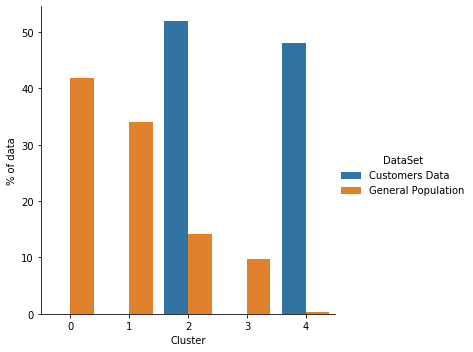

In [72]:
sns.catplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters, kind='bar')
plt.show()

In [74]:
over_cluster = 2
print(f'general population in cluster {over_cluster}: {population_freqs[over_cluster]}%')
print(f'customer population in cluster {over_cluster}: {customer_freqs[over_cluster]}%\n')
pc1_avg = (azdias_pca[population_labels == over_cluster][0].sum() + customers_pca[customers_labels == over_cluster][0].sum()) / \
          (n_population + n_customers)
pc2_avg = (azdias_pca[population_labels == over_cluster][1].sum() + customers_pca[customers_labels == over_cluster][1].sum()) / \
          (n_population + n_customers)
pc3_avg = (azdias_pca[population_labels == over_cluster][2].sum() + customers_pca[customers_labels == over_cluster][2].sum()) / \
          (n_population + n_customers)

general population in cluster 2: 14.235119047619046%
customer population in cluster 2: 51.940496316239845%



In [75]:
over_cluster = 4
print(f'general population in cluster {over_cluster}: {population_freqs[over_cluster]}%')
print(f'customer population in cluster {over_cluster}: {customer_freqs[over_cluster]}%\n')
pc1_avg = (azdias_pca[population_labels == over_cluster][0].sum() + customers_pca[customers_labels == over_cluster][0].sum()) / \
          (n_population + n_customers)
pc2_avg = (azdias_pca[population_labels == over_cluster][1].sum() + customers_pca[customers_labels == over_cluster][1].sum()) / \
          (n_population + n_customers)
pc3_avg = (azdias_pca[population_labels == over_cluster][2].sum() + customers_pca[customers_labels == over_cluster][2].sum()) / \
          (n_population + n_customers)

general population in cluster 4: 0.26112155388471175%
customer population in cluster 4: 48.05950368376015%



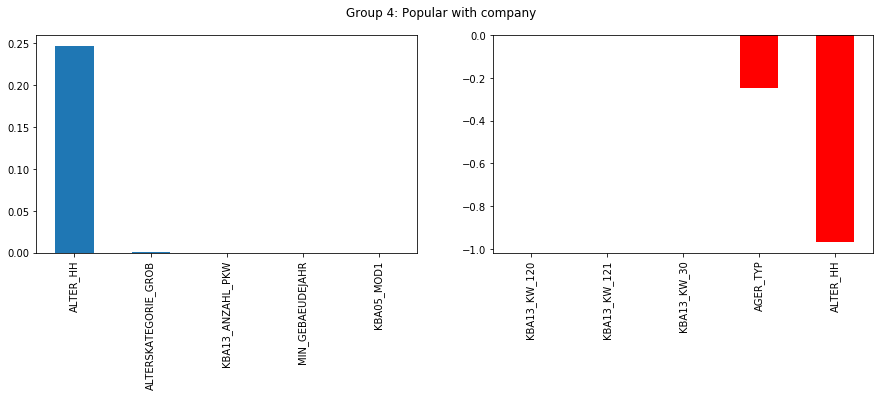

In [76]:
pca_feat_max = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=True).index[0]
fig = comp_weights(pca, pca_feat_max, pca_feat_min, 5, customers)
plt.suptitle(f'Group {over_cluster}: Popular Features within Company');
plt.savefig('assets/cluster.png')

# RESULTS

### Popular with company 
- ALTER_HH = Main age within the household (High affinity)
- ALTERSKATEGORIE_GROB =  age classification through prename analysis  (High affinity)
- AGER_TYP = Best-ager Typology (Low Affinity)
- ALTER_HH = Best-ager Typology (Low Affinity)

In [ ]:
customers['AGER_TYP'].value_counts()